# Configure Merge Module Params

This notebook should be used as a test for ensuring correct merge parameters before merge processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for merge processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [3]:
CONFIG_FILE_PATH = "config/config_B3_tiling.yml"

In [4]:
import warnings
from pathlib import Path

import yaml
import pandas as pd

from lib.shared.file_utils import get_filename
from lib.shared.configuration_utils import (
    plot_combined_tile_grid,
    plot_merge_example,
    CONFIG_FILE_HEADER,
)
from lib.merge.hash import hash_cell_locations, initial_alignment
from lib.merge.eval_alignment import plot_alignment_quality

In [ ]:
#NNJP
#change the three parquets that are saved after phenotyping, to reflect the x and y values (i.e. 180 degree rotation.)
#renamed the original outputs of phenotyping to _old. 

# phenotype_cp_min_1 = pd.read_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_cp_min_old2.parquet')
# phenotype_cp_2 = pd.read_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_cp_old2.parquet')
# phenotype_info_3 = pd.read_parquet ('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_info_old2.parquet')

In [ ]:
#NNJP
# df = phenotype_cp_min_1

# phenotype_info_inv = df.copy()

# for i in df:
#     if (i=="cell_i") | (i== "cell_j"):
#         phenotype_info_inv[i] = 2047-df[i]

# phenotype_info_inv.to_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_cp_min.parquet')

# phenotype_info_inv

In [140]:
# NNJP
# phenotype_cp_min_1.head(5)

In [ ]:
#NNJP
# df = phenotype_cp_2

# phenotype_info_inv = df.copy()

# for i in df:
#     if (i=="nucleus_i") | (i== "nucleus_j"):
#         phenotype_info_inv[i] = 2047-df[i]

# phenotype_info_inv.to_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_cp.parquet')

# phenotype_info_inv

In [142]:
#NNJP
# phenotype_cp_2.head(5)

In [ ]:
#NNJP
# df = phenotype_info_3

# phenotype_info_inv = df.copy()

# for i in df:
#     if (i=="i") | (i== "j"):
#         phenotype_info_inv[i] = 2047-df[i]

# phenotype_info_inv.to_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/phenotype/parquets/P-1_W-B3__phenotype_info.parquet')

# phenotype_info_inv

In [16]:
phenotype_metadata = pd.read_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/preprocess/metadata/phenotype/P-1_W-B3__combined_metadata.parquet')
sbs_metadata = pd.read_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/preprocess/metadata/sbs/P-1_W-B3__combined_metadata.parquet')
sbs_metadata = sbs_metadata[sbs_metadata['cycle']==1]

phenotype_xy = phenotype_metadata.rename(
    columns={"x_pos": "x", "y_pos": "y"}
).set_index("tile")[["x", "y"]]
sbs_xy = sbs_metadata.rename(columns={"x_pos": "x", "y_pos": "y"}).set_index("tile")[
    ["x", "y"]
]

In [ ]:
def multistep_alignment(
    well_triangles_0,
    well_triangles_1,
    well_locations_0,
    well_locations_1,
    det_range=(1.125, 1.186),
    score=0.1,
    initial_sites=8,
    batch_size=180,
    n_jobs=None,
):
    """Find tiles of two different acquisitions with matching Delaunay triangulations within the same well.

    Cells must not have moved significantly between acquisitions, and segmentations should be approximately equivalent.

    Args:
        well_triangles_0 (pandas.DataFrame): Hashed Delaunay triangulation for all tiles of dataset 0. Produced by
            concatenating outputs of `find_triangles` from individual tiles of a single well. Expects a `tile` column.
        well_triangles_1 (pandas.DataFrame): Hashed Delaunay triangulation for all sites of dataset 1. Produced by
            concatenating outputs of `find_triangles` from individual sites of a single well. Expects a `site` column.
        well_locations_0 (pandas.DataFrame): Table of global coordinates for each tile acquisition to match tiles
            of `well_triangles_0`. Expects `tile` as index and two columns of coordinates.
        well_locations_1 (pandas.DataFrame): Table of global coordinates for each site acquisition to match sites
            of `well_triangles_1`. Expects `site` as index and two columns of coordinates.
        det_range (tuple, optional): Range of acceptable values for the determinant of the rotation matrix
            when evaluating an alignment of a tile-site pair. The determinant measures scaling consistency
            within microscope acquisition settings. Defaults to (1.125, 1.186).
        score (float, optional): Threshold score value for filtering valid matches from spurious ones.
            Used for initial alignment. Defaults to 0.1.
        initial_sites (int | list[tuple], optional): If int, the number of sites to sample from `well_triangles_1` for initial
            brute force matching to build a global alignment model. If a list of 2-tuples, represents known
            (tile, site) matches to start building the model. Defaults to 8.
        batch_size (int, optional): Number of (tile, site) matches to evaluate per batch during global
            alignment model updates. Defaults to 180.
        n_jobs (int, optional): Number of parallel jobs to deploy using joblib. Defaults to None.

    Returns:
        pandas.DataFrame: Table of possible (tile, site) matches with corresponding rotation and translation
        transformations. All tested matches are included; query based on `score` and `determinant` to filter valid matches.
    """
    # If n_jobs is not provided, set it to one less than the number of CPU cores
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count() - 1

    # Define a function to work on individual (tile,site) pairs
    def work_on(tiles_df, sites_df):
        rotation, translation, score = evaluate_match(tiles_df, sites_df)
        determinant = None if rotation is None else np.linalg.det(rotation)
        result = pd.Series(
            {
                "rotation": rotation,
                "translation": translation,
                "score": score,
                "determinant": determinant,
            }
        )
        return result

    # use initial_sites directly to determine initial matches
    arr = []
    for tile, site in initial_sites:
        result = work_on(
            well_triangles_0.query("tile==@tile"),
            well_triangles_1.query("site==@site"),
        )
        result.at["site"] = site
        result.at["tile"] = tile
        arr.append(result)
    df_initial = pd.DataFrame(arr)

    # Unpack det_range tuple into d0 and d1
    d0, d1 = det_range

    # Define the gate condition for filtering matches based on determinant and score
    gate = "@d0 <= determinant <= @d1 & score > @score"

    # Initialize alignments list with the initial matches
    alignments = [df_initial.query(gate)]

    # Main loop for iterating until convergence
    while True:
        # Concatenate alignments and remove duplicates
        df_align = pd.concat(alignments, sort=True).drop_duplicates(["tile", "site"])

        # Extract tested and matched pairs
        tested = df_align.reset_index()[["tile", "site"]].values
        matches = df_align.query(gate).reset_index()[["tile", "site"]].values

        # Prioritize candidate pairs based on certain criteria
        candidates = prioritize(well_locations_0, well_locations_1, matches)
        candidates = remove_overlap(candidates, tested)

        print("matches so far: {0} / {1}".format(len(matches), df_align.shape[0]))

        # Prepare data for parallel processing
        work = []
        d_0 = dict(list(well_triangles_0.groupby("tile")))
        d_1 = dict(list(well_triangles_1.groupby("site")))
        for ix_0, ix_1 in candidates[:batch_size]:
            if ix_0 in d_0 and ix_1 in d_1:  # Only process if both keys exist
                # work.append([d_0[ix_0], d_1[ix_1]])
                ##NNJP replace above
                work.append((ix_0, ix_1, d_0[ix_0], d_1[ix_1]))
            else:
                print(f"Skipping tile {ix_0}, site {ix_1} - not found in data")

        if not work:  # If no valid pairs found, end alignment
            print("No valid pairs to process")
            break

        # Perform parallel processing of work
        # df_align_new = pd.concat(
        #     Parallel(n_jobs=n_jobs)(delayed(work_on)(*w) for w in work), axis=1
        # ).T.assign(
        #     tile=[t for t, _ in candidates[: len(work)]],
        #     site=[s for _, s in candidates[: len(work)]],
        # )
        # print(type(df_align_new))

        # #NNJP
        for tile_id, site_id, tile_df, site_df in work:
            result = work_on(tile_df, site_df)
            result.at["site"] = site_id
            result.at["tile"] = tile_id
            arr.append(result)
        df_align_new = pd.DataFrame(arr)

        # Append new alignments to the list
        alignments += [df_align_new]

        if len(df_align_new.query(gate)) == 0:
            break

    return df_align


def evaluate_match(
    vec_centers_0, vec_centers_1, threshold_triangle=0.3, threshold_point=2
):
    """Evaluates the match between two sets of vectors and centers.

    Computes the transformation parameters (rotation and translation) and evaluates the quality of the match between two datasets based on their vectors and centers.

    Args:
        vec_centers_0 (pandas.DataFrame): DataFrame containing the first set of vectors and centers.
        vec_centers_1 (pandas.DataFrame): DataFrame containing the second set of vectors and centers.
        threshold_triangle (float, optional): Threshold for matching triangles. Defaults to 0.3.
        threshold_point (float, optional): Threshold for matching points. Defaults to 2.

    Returns:
        tuple:
            - numpy.ndarray: Rotation matrix of the transformation.
            - numpy.ndarray: Translation vector of the transformation.
            - float: Score of the transformation based on the matching points.
    """
    V_0, c_0 = get_vc(
        vec_centers_0
    )  # Extract vectors and centers from the first DataFrame
    V_1, c_1 = get_vc(
        vec_centers_1
    )  # Extract vectors and centers from the second DataFrame

    i0, i1, distances = nearest_neighbors(
        V_0, V_1
    )  # Find nearest neighbors between the vectors

    # Filter triangles based on distance threshold
    filt = distances < threshold_triangle
    X, Y = c_0[i0[filt]], c_1[i1[filt]]  # Get the matching centers

    # Minimum number of matching triangles required to proceed
    if sum(filt) < 5:
        return None, None, -1

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # Use matching triangles to define transformation
        model = RANSACRegressor()
        model.fit(X, Y)  # Fit the RANSAC model to the matching centers

    rotation = model.estimator_.coef_  # Extract rotation matrix
    translation = model.estimator_.intercept_  # Extract translation vector

    # Score transformation based on the triangle centers
    distances = cdist(model.predict(c_0), c_1, metric="sqeuclidean")
    threshold_region = 50  # Threshold for the region to consider
    filt = np.sqrt(distances.min(axis=0)) < threshold_region
    score = (
        np.sqrt(distances.min(axis=0))[filt] < threshold_point
    ).mean()  # Calculate score

    return rotation, translation, score  # Return rotation, translation, and score


def get_vc(vec_centers, normalize=True):
    """Extracts vectors and centers from the DataFrame, with optional normalization of vectors.

    Args:
        vec_centers (pandas.DataFrame): DataFrame containing vectors and centers.
        normalize (bool, optional): Whether to normalize the vectors. Defaults to True.

    Returns:
        tuple:
            - numpy.ndarray: Array of vectors.
            - numpy.ndarray: Array of centers.
    """
    V, c = (
        vec_centers.filter(like="V").values,
        vec_centers.filter(like="c").values,
    )  # Extract vectors and centers
    if normalize:
        V = (
            V / vec_centers["magnitude"].values[:, None]
        )  # Normalize the vectors by their magnitudes
    return V, c  # Return vectors and centers


def nearest_neighbors(V_0, V_1):
    """Computes the nearest neighbors between two sets of vectors.

    Args:
        V_0 (numpy.ndarray): First set of vectors.
        V_1 (numpy.ndarray): Second set of vectors.

    Returns:
        tuple:
            - numpy.ndarray: Indices of the nearest neighbors in `V_0`.
            - numpy.ndarray: Indices of the nearest neighbors in `V_1`.
            - numpy.ndarray: Distances between the nearest neighbors.
    """
    Y = cdist(V_0, V_1, metric="sqeuclidean")  # Compute squared Euclidean distances
    distances = np.sqrt(
        Y.min(axis=1)
    )  # Compute the smallest distances and take the square root
    ix_0 = np.arange(V_0.shape[0])  # Indices of V_0
    ix_1 = Y.argmin(axis=1)  # Indices of nearest neighbors in V_1
    return ix_0, ix_1, distances  # Return indices and distances


def prioritize(well_locations_0, well_locations_1, matches):
    """Produce an Nx2 array of tile (site) identifiers predicted to match within a search radius based on existing matches.

    Args:
        well_locations_0 (pandas.DataFrame): DataFrame containing tile (site) information for the first set.
        well_locations_1 (pandas.DataFrame): DataFrame containing tile (site) information for the second set.
        matches (numpy.ndarray): Nx2 array of tile (site) identifiers representing existing matches.

    Returns:
        list of tuple: List of predicted matching tile (site) identifiers.
    """
    a = well_locations_0.loc[
        matches[:, 0]
    ].values  # Get coordinates of matching tiles from the first set
    b = well_locations_1.loc[
        matches[:, 1]
    ].values  # Get coordinates of matching tiles from the second set

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # allow testing with subset of tiles
        if a.shape[0] == a.shape[1]:
            model = RANSACRegressor(min_samples=1)
        else:
            model = RANSACRegressor()
        model.fit(a, b)  # Fit the RANSAC model to the matching coordinates

    # Predict coordinates for the first set and calculate distances to the second set
    predicted = model.predict(well_locations_0.values)
    distances = cdist(predicted, well_locations_1.values, metric="sqeuclidean")
    ix = np.argsort(distances.flatten())  # Sort distances to find the closest matches
    ix_0, ix_1 = np.unravel_index(
        ix, distances.shape
    )  # Get indices of the closest matches

    candidates = list(
        zip(well_locations_0.index[ix_0], well_locations_1.index[ix_1])
    )  # Create list of candidate matches

    return remove_overlap(candidates, matches)  # Remove overlapping matches


def remove_overlap(xs, ys):
    """Remove overlapping pairs from a list of candidates based on an existing set of matches.

    Args:
        xs (list of tuple): List of candidate pairs.
        ys (list of tuple): List of existing matches.

    Returns:
        list of tuple: List of candidate pairs with overlaps removed.
    """
    ys = set(
        map(tuple, ys)
    )  # Convert existing matches to a set of tuples for fast lookup
    return [
        tuple(x) for x in xs if tuple(x) not in ys
    ]  # Return candidates that are not in existing matches

import warnings
import multiprocessing
from collections.abc import Iterable

import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
from sklearn.linear_model import RANSACRegressor
from joblib import Parallel, delayed

In [25]:
print(np.unique(sbs_info_hash['site']))
print(np.unique(phenotype_info_hash['tile']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[  2   3   4   5   8   9  10  11  12  13  14  17  18  19  20  21  22  23
  24  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  83  84  85  86  87  88  89  90  91  94  95  96  97  98  99
 100 103 104 105 107]


In [67]:
df = multistep_alignment(phenotype_info_hash, sbs_info_hash, phenotype_xy, sbs_xy, 
    det_range=(0.225, 0.2875),
    score=0.1,
    initial_sites=[[54,12], [74,16], [11,2], [30,6], [9,3], [78,18]],
    batch_size=180,
    n_jobs=None)

matches so far: 6 / 6
Skipping tile 7, site 4 - not found in data
Skipping tile 15, site 0 - not found in data
Skipping tile 93, site 24 - not found in data
Skipping tile 101, site 20 - not found in data
Skipping tile 1, site 1 - not found in data
Skipping tile 92, site 24 - not found in data
Skipping tile 16, site 0 - not found in data
Skipping tile 26, site 5 - not found in data
Skipping tile 102, site 20 - not found in data
Skipping tile 6, site 4 - not found in data
Skipping tile 26, site 4 - not found in data
Skipping tile 108, site 23 - not found in data
Skipping tile 82, site 20 - not found in data
Skipping tile 16, site 9 - not found in data
Skipping tile 6, site 3 - not found in data
<class 'pandas.core.frame.DataFrame'>
matches so far: 156 / 171
Skipping tile 82, site 19 - not found in data
Skipping tile 6, site 3 - not found in data
Skipping tile 0, site 1 - not found in data
Skipping tile 16, site 9 - not found in data
Skipping tile 102, site 21 - not found in data
Skipping

In [68]:
gate = "0.225 <= determinant <= 0.2875 & score > 0.1"
df2 = df.query(gate)
# len(np.sort(df2['tile'].unique()))
df[df['tile']==55]

,determinant,rotation,score,site,tile,translation
56,0.250148,"[[0.49941264264230983, 0.0030910101018845897],...",0.739336,11,55,"[353.694489887699, 1399.2961211495199]"
57,NaN,NaN,-1.0,12,55,NaN


In [ ]:
#NNJP output
gate = "0.225 <= determinant <= 0.2875 & score > 0.1"
df2 = df.query(gate)
# len(np.sort(df2['tile'].unique()))
df[df['tile']==55]

,determinant,rotation,score,site,tile,translation
58,0.250201,"[[0.49995695456977457, 0.0029111454964902907],...",0.681633,11.0,55.0,"[464.3744026342875, -558.1415333507482]"
59,0.250174,"[[0.49956140193791687, 0.0029171402281269686],...",0.684086,12.0,55.0,"[464.64009406350107, 1303.3440228330905]"
300,NaN,NaN,-1.000000,17.0,55.0,NaN
353,NaN,NaN,-1.000000,7.0,55.0,NaN
369,NaN,NaN,-1.000000,18.0,55.0,NaN
377,NaN,NaN,-1.000000,8.0,55.0,NaN
508,NaN,NaN,-1.000000,13.0,55.0,NaN
586,NaN,NaN,-1.000000,10.0,55.0,NaN
736,0.418470,"[[0.35874750874636013, -1.0044609359626102], [...",0.010283,16.0,55.0,"[1433.884719582231, 1469.4526676729654]"
741,NaN,NaN,-1.000000,6.0,55.0,NaN


In [30]:
work = []
d_0 = dict(list(phenotype_info_hash.groupby("tile")))
d_1 = dict(list(sbs_info_hash.groupby("site")))
for ix_0, ix_1 in [[55,12],[55,11]]:
    if ix_0 in d_0 and ix_1 in d_1:  # Only process if both keys exist
        work.append([d_0[ix_0], d_1[ix_1]])
    else:
        print(f"Skipping tile {ix_0}, site {ix_1} - not found in data")

df_align_new = pd.concat(
    Parallel(n_jobs=None)(delayed(work_on2)(*w) for w in work), axis=1
).T.assign(
    tile=[t for t, _ in [(55,12),(55,11)][: len(work)]],
    site=[s for _, s in [(55,12),(55,11)][: len(work)]],
        )

df_align_new

,rotation,translation,score,determinant,tile,site
0,"[[0.49956140193791687, 0.0029171402281269686],...","[464.64009406350107, 1303.3440228330905]",0.684086,0.250174,55,12
1,"[[0.49995695456977457, 0.0029111454964902907],...","[464.3744026342875, -558.1415333507482]",0.681633,0.250201,55,11


In [ ]:
#initial alignment

def work_on2(tiles_df, sites_df):
        rotation, translation, score = evaluate_match(tiles_df, sites_df)
        determinant = None if rotation is None else np.linalg.det(rotation)
        result = pd.Series(
            {
                "rotation": rotation,
                "translation": translation,
                "score": score,
                "determinant": determinant,
            }
        )
        return result

arr=[]
for tile, site in [[55,12],[55,11]]:
    result = work_on2(
        phenotype_info_hash.query("tile==@tile"),
        sbs_info_hash.query("site==@site"),
    )
    result.at["site"] = site
    result.at["tile"] = tile
    arr.append(result)

pd.DataFrame(arr)



,rotation,translation,score,determinant,site,tile
0,"[[0.49956140193791687, 0.0029171402281269686],...","[464.64009406350107, 1303.3440228330905]",0.684086,0.250174,12,55
1,"[[0.49995695456977457, 0.0029111454964902907],...","[464.3744026342875, -558.1415333507482]",0.681633,0.250201,11,55


In [73]:
#read in merge parquet
test = pd.read_parquet ('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/merge/parquets/P-1_W-B3__merge_final.parquet')
test[test["site"]==12]

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
6,1,B3,53,93,1485.172783,1463.210245,12,840,1204.046122,272.496855,...,0.041951,0.078915,0.087609,0.042632,0.011636,0,0.0,63.711956,73.976314,175.064482
8,1,B3,66,90,1473.417513,1498.280116,12,237,318.941345,294.341917,...,0.075007,0.126794,0.094644,0.031089,0.095999,0,0.0,82.420017,107.856714,168.136140
41,1,B3,65,92,1524.774341,1482.152130,12,260,348.465160,1165.627119,...,0.032652,0.075405,0.059230,0.093828,0.006252,0,0.0,94.270151,97.687411,72.292998
68,1,B3,53,100,1453.359886,1527.768848,12,833,1188.237762,304.682984,...,0.225269,0.112959,0.153060,0.080069,0.034620,0,0.0,73.976314,74.870541,74.524510
97,1,B3,65,114,1412.220365,1485.482270,12,212,292.459042,1167.156105,...,0.279254,0.218467,0.117779,0.054179,0.007228,0,0.0,80.901505,103.833787,110.262097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21502,1,B3,42,212,472.956788,201.423563,12,1080,1579.866776,1398.297697,...,0.041830,0.127850,0.050014,0.087322,0.068785,0,0.0,64.501710,93.127961,172.970023
21531,1,B3,43,224,282.668560,346.713991,12,1025,1482.362098,592.901861,...,0.154678,0.306527,0.239250,0.113894,0.051442,0,0.0,71.080562,113.542779,171.403121
21536,1,B3,55,234,265.235004,361.558466,12,446,598.584906,1483.559299,...,0.239679,0.122843,0.179306,0.185737,0.062287,0,0.0,45.606560,111.896416,38.310163
21537,1,B3,54,270,339.232075,284.654245,12,470,630.907638,565.884547,...,0.225739,0.011426,0.144799,0.076856,0.024865,0,0.0,63.653185,110.004085,45.627448


In [96]:
test[~test["sgRNA_0"].isna()]

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,B3,79,133,1476.583224,1481.078637,19,799,1317.510363,81.660622,...,0.110376,0.140847,0.150343,0.086814,0.038103,0,0.000000,70.382660,74.967556,139.270785
1,1,B3,89,79,1483.484387,1489.277989,16,295,425.193925,1282.058411,...,0.111852,0.159309,0.026245,0.025549,0.058736,0,0.000000,75.248459,82.965015,164.310330
2,1,B3,49,39,1471.584567,1474.647992,14,797,1181.812217,485.255656,...,0.098928,0.350046,0.115352,0.094121,0.022239,0,0.000000,72.125047,76.594138,152.982230
4,1,B3,87,97,1486.181599,1464.814066,17,317,432.564655,1163.978448,...,0.094902,0.181016,0.045699,0.065087,0.029924,1,0.090069,49.743784,86.217058,113.426541
5,1,B3,75,103,1478.863547,1463.289029,17,948,1304.076175,279.946515,...,0.022365,0.219168,0.051595,0.202204,0.098862,0,0.000000,69.162347,107.017627,127.513489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21651,1,B3,60,156,138.842041,124.985419,19,954,1529.294118,1163.212670,...,0.060500,0.031447,0.019997,0.011568,0.028796,1,0.066879,50.068090,55.626018,101.616773
21653,1,B3,4,122,119.757823,91.012245,3,1113,1190.128655,1432.939571,...,0.132488,0.096798,0.063290,0.053903,0.042238,2,0.166078,44.190359,80.304584,117.288177
21654,1,B3,60,160,46.848710,145.925595,19,918,1483.974194,1173.830108,...,0.139169,0.144081,0.127916,0.054286,0.075588,0,0.000000,73.930496,83.000542,43.985193
21656,1,B3,4,142,93.066176,66.521242,3,1105,1177.280936,1419.986622,...,0.150053,0.094614,0.091640,0.067162,0.043058,1,0.100559,44.190359,52.330670,130.438048


In [144]:
#NNJP
# phenotype_info_3.head(5)

In [ ]:
# #NNJP change metadata parquet files to account for stage offset. 
# #1. renamed /scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/preprocess/metadata/phenotype/P-1_W-B3__combined_metadata.parquet to _old.
# #2. import old, change X and Y positions according to offset, then re-save.
# import numpy as np
# ph_tiles = [i[0] for i in [[54,12], [74,16], [11,2], [30,6], [9,3], [78,18], [11,2]]]
# sbs_tiles = [i[1] for i in [[54,12], [74,16], [11,2], [30,6], [9,3], [78,18], [11,2]]]

# ph_subset = ph_test_metadata[ph_test_metadata['tile'].isin(ph_tiles)]
# sbs_subset = sbs_test_metadata[sbs_test_metadata['tile'].isin(sbs_tiles)]

# ph_copy = pd.read_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/preprocess/metadata/phenotype/P-1_W-B3__combined_metadata_old.parquet')
# ph_copy_update = ph_copy.copy()
# ph_copy_update['x_pos'] = ph_copy['x_pos']-(np.mean(ph_subset['x_pos']) - np.mean(sbs_subset['x_pos']))
# ph_copy_update['y_pos'] = ph_copy['y_pos']-(np.mean(ph_subset['y_pos']) - np.mean(sbs_subset['y_pos']))

# ph_copy_update.to_parquet('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/preprocess/metadata/phenotype/P-1_W-B3__combined_metadata.parquet')


In [34]:
# test = pd.read_parquet ('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/merge2_changedmetadata/parquets/P-1_W-B3__merge_final.parquet')
# test[test["tile"]==55]

test = pd.read_parquet ('/scratch/gpfs/nj6532/data/microscopy/NNJP/20250819_NNJPplate57/for_brieflow/brieflow_outputs/B3_tiling/merge2_changedmetadata/parquets/P-1_W-B3__fast_alignment.parquet')
test[test["tile"]==75]

,determinant,score,site,tile,translation,rotation_1,rotation_2,plate,well
39,0.249981,0.695652,16,75,"[-536.1776393171654, 629.5748576184513]","[0.4999863299684726, 0.0032193281612945854]","[-0.0036289556081281595, 0.4999516192012406]",1,B3
105,NaN,-1.000000,17,75,None,[],[],1,B3
325,1.525937,0.003555,22,75,"[-491.6320912342032, 1806.2313619686597]","[1.7323931201920322, 0.32363150235917093]","[-3.4919640040668467, 0.2284858940752576]",1,B3


In [33]:
from lib.merge.hash import hash_cell_locations, initial_alignment, multistep_alignment

## <font color='red'>SET PARAMETERS</font>

### Determine merge plate-well combos
- `MERGE_COMBO_DF_FP`: Plate used for testing configuration

In [5]:
MERGE_COMBO_DF_FP = "config/merge_combo_B3_tiling.tsv"

In [6]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

SBS_COMBO_FP = Path(config["preprocess"]["sbs_combo_fp"])
sbs_wildcard_combos = pd.read_csv(SBS_COMBO_FP, sep="\t")
PHENOTYPE_COMBO_FP = Path(config["preprocess"]["phenotype_combo_fp"])
phenotype_wildcard_combos = pd.read_csv(PHENOTYPE_COMBO_FP, sep="\t")

# Generate plate-well combinations for merge
sbs_combos = set(zip(sbs_wildcard_combos["plate"], sbs_wildcard_combos["well"]))
phenotype_combos = set(
    zip(phenotype_wildcard_combos["plate"], phenotype_wildcard_combos["well"])
)
# Check if SBS and PHENOTYPE have the same plate-well combinations
if sbs_combos == phenotype_combos:
    merge_wildcard_combos = pd.DataFrame(list(sbs_combos), columns=["plate", "well"])
else:
    warnings.warn(
        "SBS and PHENOTYPE do not have matching plate-well combinations. Merging requires identical sets."
    )
    merge_wildcard_combos = pd.DataFrame(columns=["plate", "well"])

merge_wildcard_combos.to_csv(MERGE_COMBO_DF_FP, sep="\t", index=False)
merge_wildcard_combos

,plate,well
0,1,B3


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge module
- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration 

### Parameters for metadata extraction
- `SBS_METADATA_CYCLE`: Cycle number for extracting SBS data positions
- `SBS_METADATA_CHANNEL`: Optional channel for SBS metadata. This is necessary in the case that multiple channel-based images were acquired, and therefore, multiple channel-based metadata files exist.
- `PH_METADATA_CHANNEL`: Optional channel for phenotype metadata. This is necessary in the case that multiple channel-based images were acquired, and therefore, multiple channel-based metadata files exist.

In [7]:
TEST_PLATE = 1
TEST_WELL = "B3"

SBS_METADATA_CYCLE = 1
SBS_METADATA_CHANNEL = None
PH_METADATA_CHANNEL = None

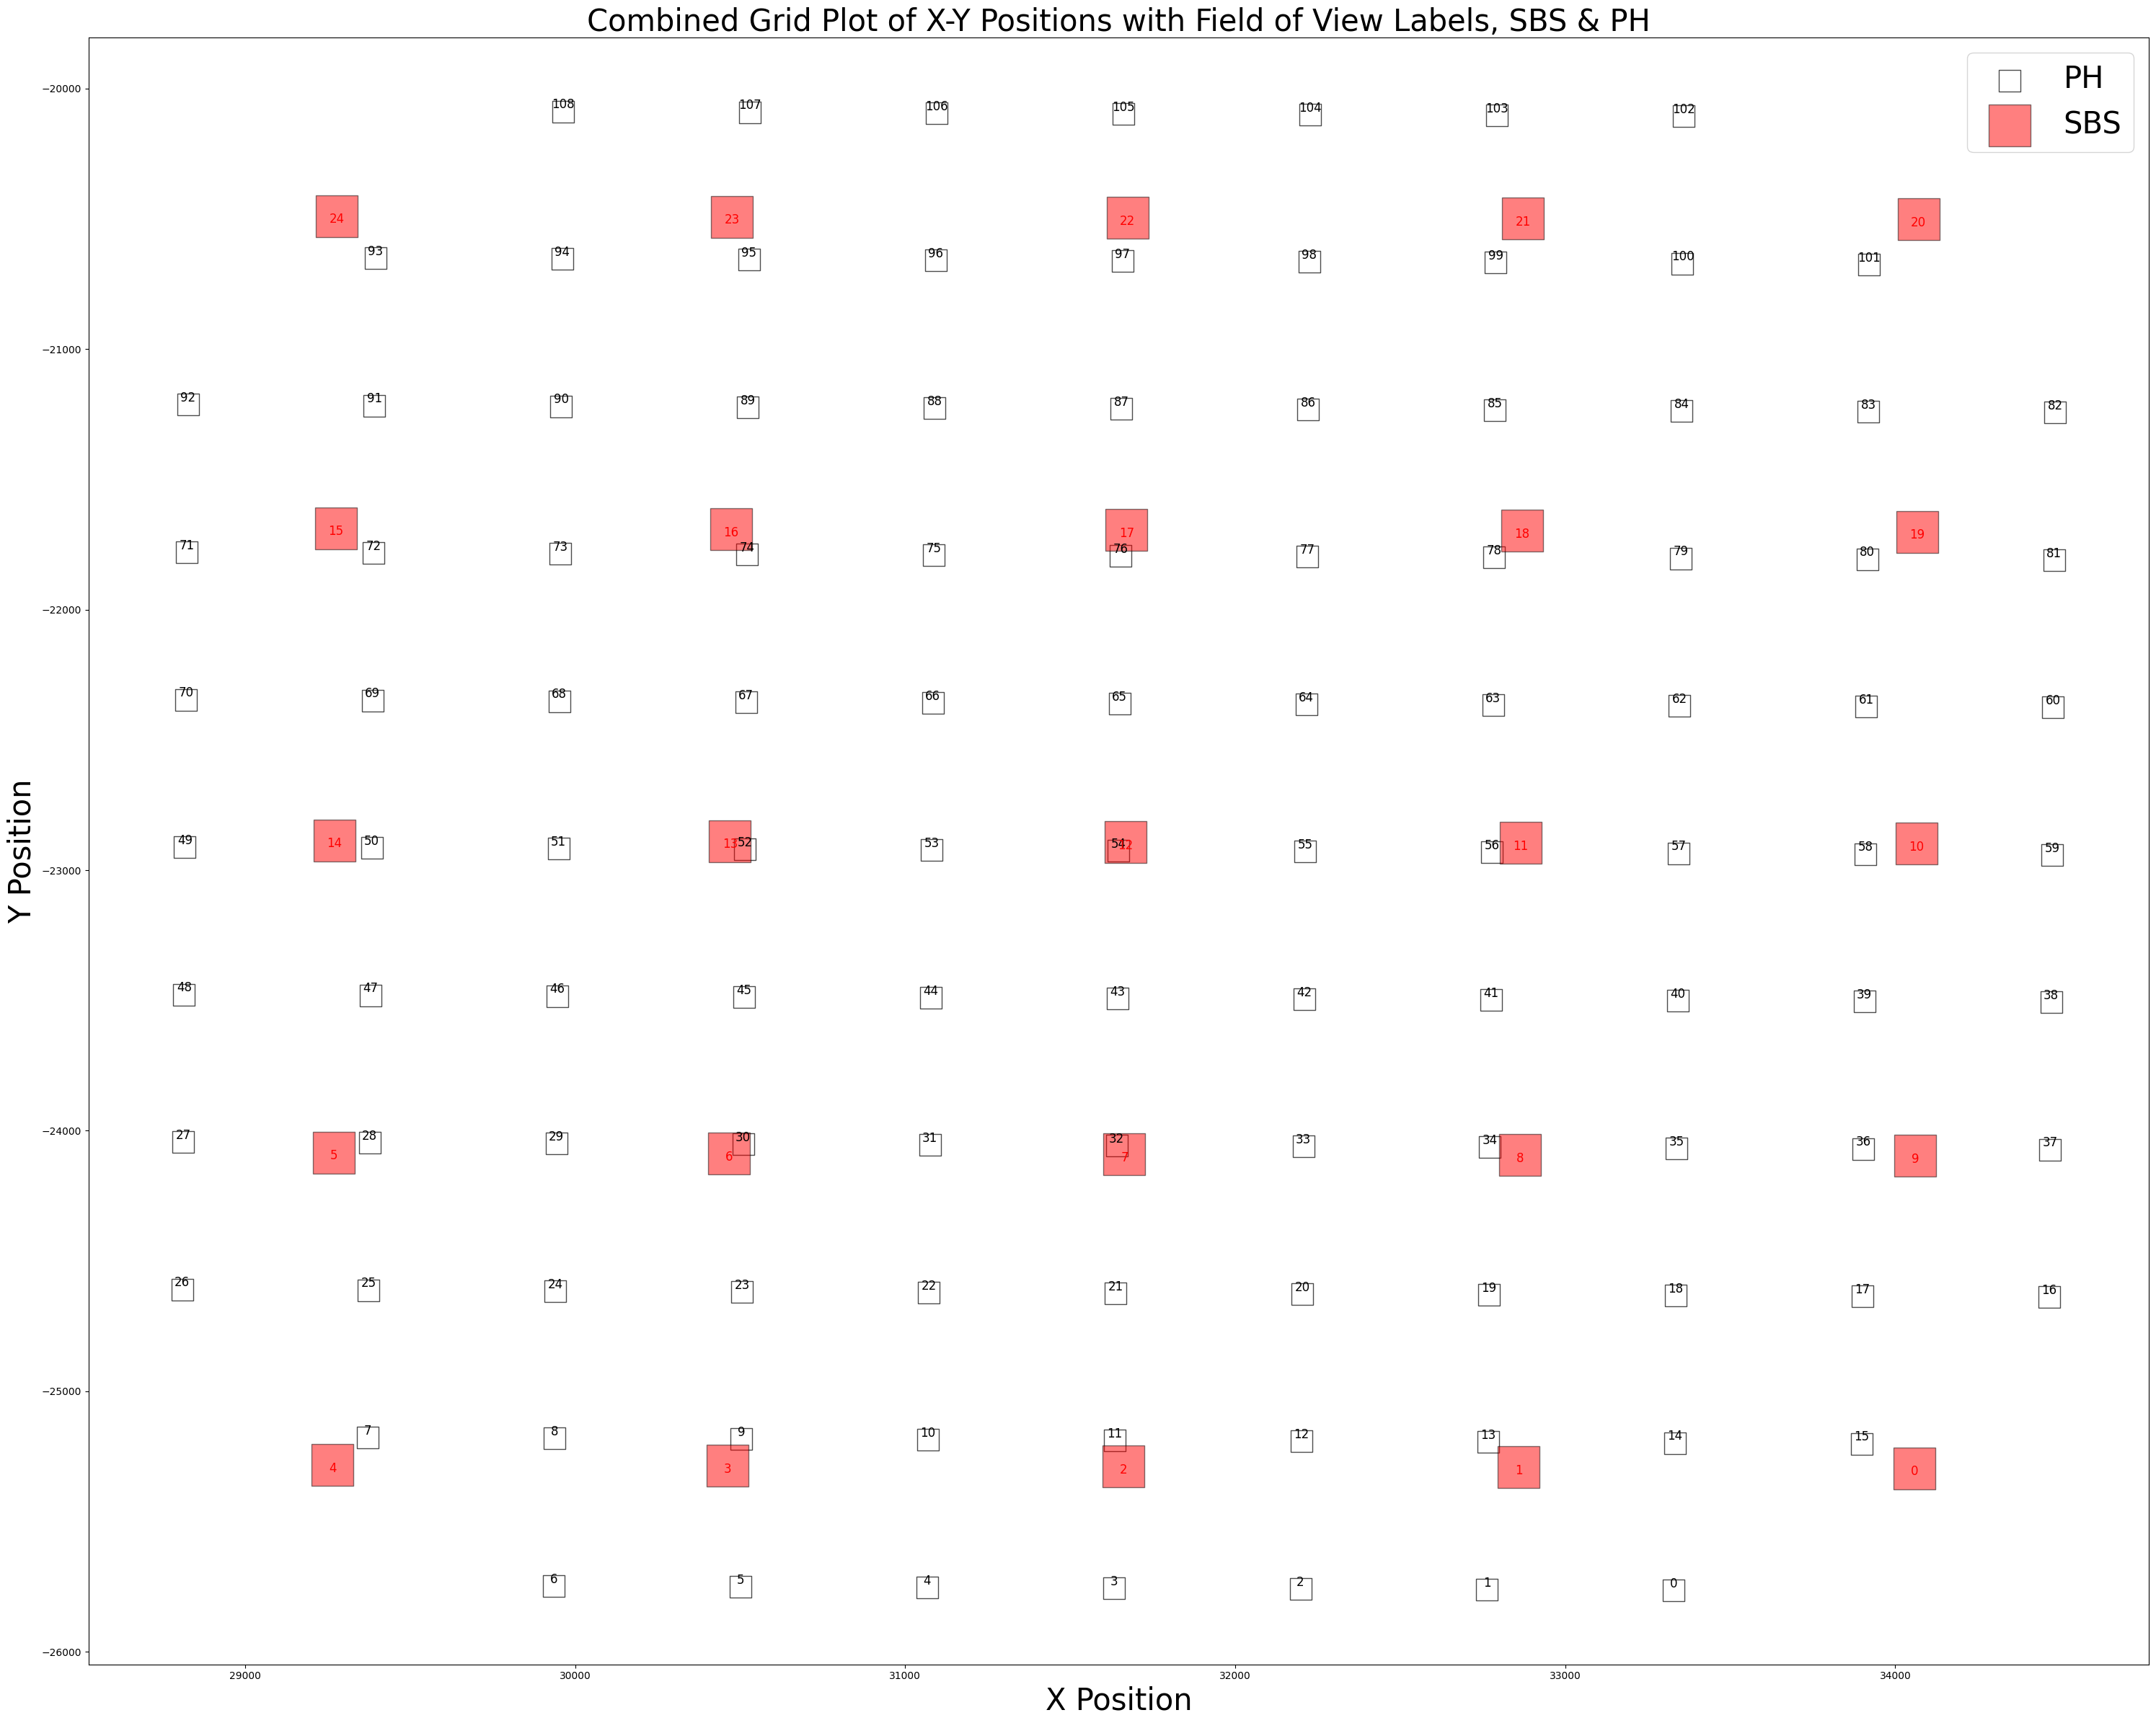

In [8]:
ROOT_FP = Path(config["all"]["root_fp"])

# load phenotype and SBS metadata dfs
ph_filename_params = {"plate": TEST_PLATE, "well": TEST_WELL}
if PH_METADATA_CHANNEL is not None:
    ph_filename_params["channel"] = PH_METADATA_CHANNEL

ph_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "phenotype"
    / get_filename(ph_filename_params, "combined_metadata", "parquet")
)
ph_test_metadata = pd.read_parquet(ph_test_metadata_fp)

sbs_filename_params = {"plate": TEST_PLATE, "well": TEST_WELL}
if SBS_METADATA_CHANNEL is not None:
    sbs_filename_params["channel"] = SBS_METADATA_CHANNEL

sbs_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "sbs"
    / get_filename(sbs_filename_params, "combined_metadata", "parquet")
)
sbs_test_metadata = pd.read_parquet(sbs_test_metadata_fp)
sbs_test_metadata = sbs_test_metadata[sbs_test_metadata["cycle"] == SBS_METADATA_CYCLE]

# create plot with combined tile view
combined_tile_grid = plot_combined_tile_grid(ph_test_metadata, sbs_test_metadata)
combined_tile_grid.show()
#NNJP
# combined_tile_grid = plot_combined_tile_grid(ph_copy, sbs_test_metadata)
# combined_tile_grid.show()

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge processing

- `INITIAL_SITES`: Combinations of phenotype and SBS tiles used for configuring merge module parameters. Based on the combined grid above, set 6 aligned intial sites. We will load images for one of those sites, to ensure that we can visualize cell patterns (using the DAPI channel) that correspond between two tiles that will make up our initial sites. We recommend using aligned sites from across the plate.

In [ ]:
INITIAL_SITES = [[[54,12], [74,16], [11,2], [30,6], [9,3], [78,18]]]
# INITIAL_SITES = [[55,11],[55,12]]

In [27]:
# Derive sites for phenotype and sbs
phenotype_tiles = [site[0] for site in INITIAL_SITES]
sbs_tiles = [site[1] for site in INITIAL_SITES]

# Derive phenotype alignment hash
phenotype_info_fp = (
    ROOT_FP
    / "phenotype"
    / "parquets"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL}, "phenotype_info", "parquet"
    )
)
phenotype_info = pd.read_parquet(phenotype_info_fp)
phenotype_info_hash = hash_cell_locations(phenotype_info)
#NNJP
# phenotype_info_hash_inv = invert_hash(phenotype_info_hash)

# Derive SBS alignment hash
sbs_info_fp = (
    ROOT_FP
    / "sbs"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "sbs_info", "parquet")
)
sbs_info = pd.read_parquet(sbs_info_fp)
sbs_info_hash = hash_cell_locations(sbs_info).rename(columns={"tile": "site"})

# # Perform alignment for initial sites
# initial_alignment_df = initial_alignment(
#     phenotype_info_hash, sbs_info_hash, initial_sites=INITIAL_SITES
# )

#NNJP
# Perform alignment for initial sites
initial_alignment_df = initial_alignment(
    phenotype_info_hash, sbs_info_hash, initial_sites=INITIAL_SITES
)

initial_alignment_df

,rotation,translation,score,determinant,site,tile
0,NaN,NaN,-1.0,NaN,5.0,26.0


## <font color='red'>SET PARAMETERS</font>

### Visualize gating strategy based on initial alignment

- `DET_RANGE`: Enforces valid magnification ratios between phenotype and genotype images.
  - The determinant range accounts for differences in:
    - Objective magnifications (e.g., 20X vs 10X)
    - Camera binning settings (e.g., 2x2 vs unbinned)
  - Calculation formula:
    - If magnification ratio = M and binning ratio = B
    - Total difference factor = M × B
    - `DET_RANGE` = [0.9/(M×B)², 1.15/(M×B)²]
  - Example:
    - With 2× magnification difference and 2× binning difference
    - Total difference factor = 2 × 2 = 4
    - `DET_RANGE` = [0.9/16, 1.15/16] = [0.056, 0.072]
  - Adjust range as needed for matching precision
- `SCORE`: This parameter is the score of the transformation, typically 0.1

In [11]:
DET_RANGE = [0.225,0.2875]
SCORE = 0.1

# DET_RANGE = [-0.5,0.2875]
# SCORE = 0.005

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Alignment Quality Check\nScore vs Determinant'}, xlabel='Determinant', ylabel='Score'>)

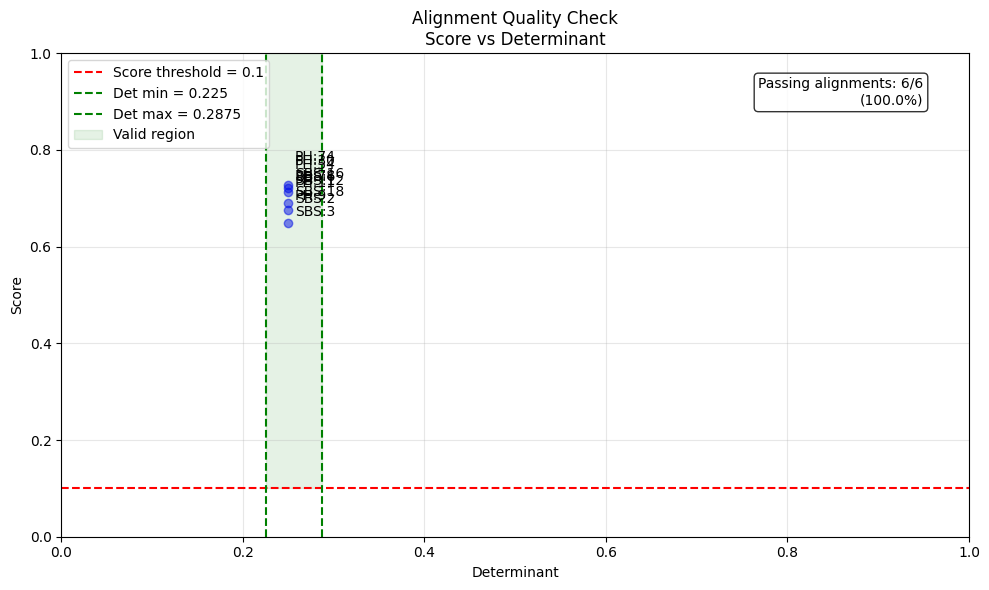

In [12]:
plot_alignment_quality(
    initial_alignment_df, det_range=DET_RANGE, score=SCORE, xlim=(0, 1), ylim=(0, 1)
)

## <font color='red'>SET PARAMETERS</font>

### Visualize cell matches based on initial alignment

- `THRESHOLD`: Determines the maximum euclidean distance between a phenotype point and its matched SBS point for them to be considered a valid match

In [13]:
THRESHOLD = 10

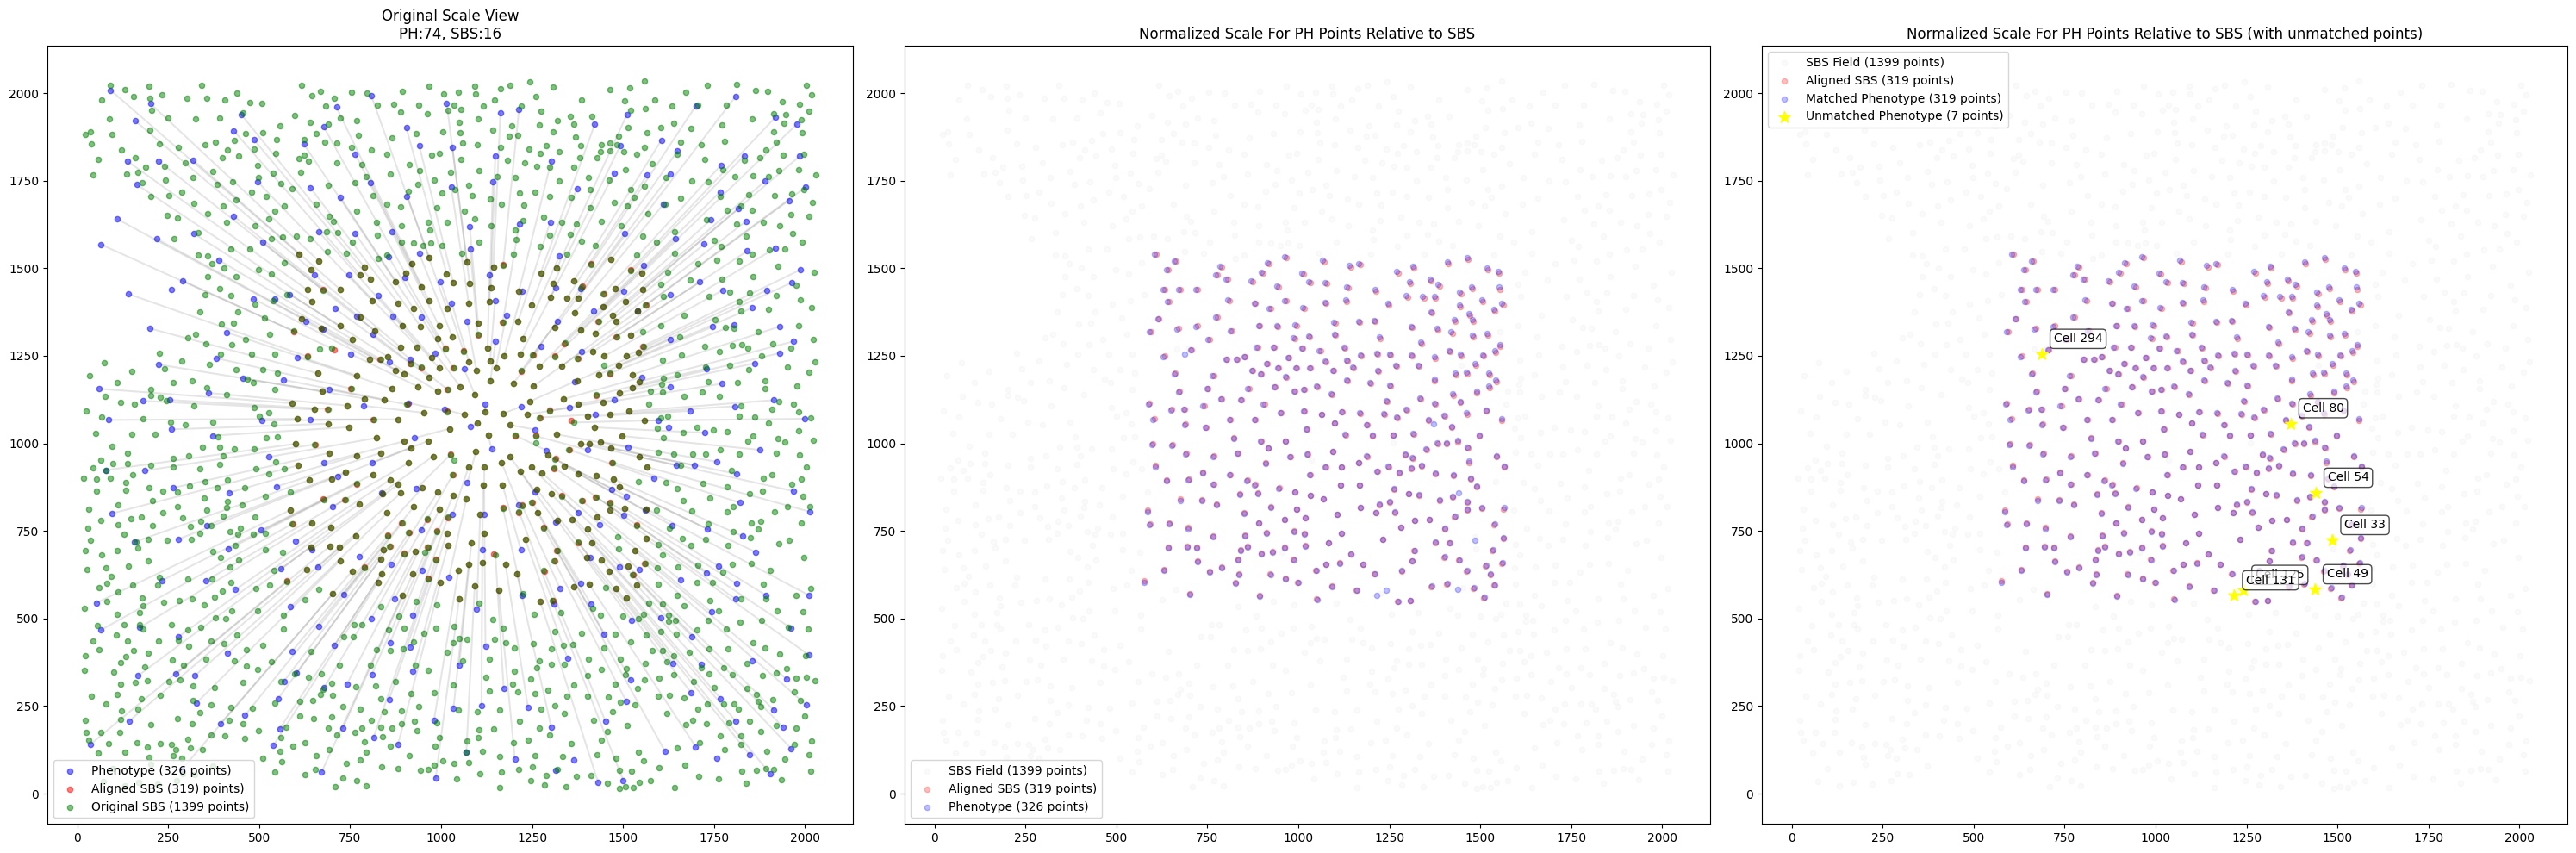

In [14]:
site_id = 1

alignment_vec_example = initial_alignment_df[
    (initial_alignment_df["tile"] == INITIAL_SITES[site_id][0])
    & (initial_alignment_df["site"] == INITIAL_SITES[site_id][1])
].iloc[0]

plot_merge_example(
    phenotype_info,
    sbs_info,
    alignment_vec_example,
    threshold=THRESHOLD,
)

## Add merge parameters to config file

In [15]:
# Add merge section
config["merge"] = {
    "merge_combo_fp": MERGE_COMBO_DF_FP,
    "sbs_metadata_cycle": SBS_METADATA_CYCLE,
    "sbs_metadata_channel": SBS_METADATA_CHANNEL,
    "ph_metadata_channel": PH_METADATA_CHANNEL,
    "initial_sites": INITIAL_SITES,
    "det_range": DET_RANGE,
    "score": SCORE,
    "threshold": THRESHOLD,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-stylåe comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)